# Download,  Parse and Interrogate Apple Health Export Data

This file was created from a desire to get my hands on data collected by Apple Health, notably heart rate information collected by Apple Watch. For this to work, this file needs to be in a location accessible to Python code. A little bit of searching told me that iCloud file access is problematic and that there were already a number of ways of doing this with the Google API if the file was saved to Google Drive. I chose PyDrive. So for the end to end program to work with little user intervention, you will need to sign up for Google Drive, set up an application in the Google API and install Google Drive app to your iPhone. 

This may sound involved, and it is not necessary if you simply email the export file to yourself and copy it to a filesystem that Python can see. If you choose to do that, all of the Google Drive portion can be removed. I like the Google Drive process though as it enables a minimal manual work scenario.

This version requires the user to grant Google access, requiring some additional clicks, but it is not too much. I think it is possible to automate this to run without user intervention as well using security files.

The first step to enabling this process is exporting the data from Apple Health. As of this writing, open Apple Health and click on your user icon or photo. Near the bottom of the next page in the app will be a button or link called Export Health Data. Clicking on this will generate a xml file, zipped up. THe next dialog will ask you where you want to save it. Options are to email, save to iCloud, message etc...  Select Google Drive. Google Drive allows multiple  files with the same name and this is accounted for by this program.

In [1]:
import xml.etree.ElementTree as et
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re 
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

##  Authenticate with Google 
This will open a browser to let you beging the process of authentication with an existing Google Drive account. This process will be separate from Python. For this to work, you will need to set up a Other Authentication OAuth credential at https://console.developers.google.com/apis/credentials, save the secret file in your root directory and a few other things that are detailed at https://pythonhosted.org/PyDrive/. The PyDrive instructions also show you how to set up your Google application. There are other methods for accessing the Google API from python, but this one seems pretty nice. 
The first time through the process, regular sign in and two factor authentication is required (if you require two factor auth) but after that it is just a process of telling Google that it is ok for your Google application to access Drive.

In [2]:
# Authenticate into Google Drive
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() 

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=643038572377-3l8prnqdfm6o5ualucljs78l9vao60qb.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


### Download the most recent Apple Health export file
Now that we are authenticated into Google Drive, use PyDrive to access the API and get to files stored.

Google Drive allows multiple files with the same name, but it indexes them with the ID to keep them separate.
In this block, we make one pass of the file list where the file name is called export.zip, and save the row that corresponds with the most recent date. We will use that  file id later to download the correct file that corresponds  with the most recent date. Apple Health export names the file export.zip, and at the time this was written, there is no other option.

In [3]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

# Step through the file list and find the most current export.zip file id, then use 
#      that later to download the file to the local machine.
# This may look a little old school, but these file lists will never be massive and 
#     it is readable and easy one pass way to get the most current file using the 
#     least (or low) amount of resouces
selection_dt = datetime.strptime("2000-01-01T01:01:01.001Z","%Y-%m-%dT%H:%M:%S.%fZ")
print("Matching Files")
for file1 in file_list: 
    if re.search("^export.zip",file1['title']):
        dt = datetime.strptime(file1['createdDate'],"%Y-%m-%dT%H:%M:%S.%fZ")
        if dt > selection_dt:
            selection_id = file1['id']
            selection_dt = dt
        print('    title: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))

Matching Files
    title: export.zip, id: 0B_EXRCwLorf3SlJZeG53YjlVczg createDate: 2017-06-08T12:36:33.740Z
    title: export.zip, id: 0B_EXRCwLorf3ZWptengzckVOQ2s createDate: 2017-06-05T10:55:13.920Z
    title: export.zip, id: 0B_EXRCwLorf3dXl6bHUwWl9DMG8 createDate: 2017-06-03T19:34:54.262Z
    title: export.zip, id: 0B_EXRCwLorf3amN5alQ0R3VDMm8 createDate: 2017-06-02T10:06:54.992Z


## Download the file from Google Drive
Ensure that the file downloaded is the latest file generated

In [5]:
for file1 in file_list:
        if file1['id'] == selection_id:
            print('Downloading this file: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))
            file1.GetContentFile("healthextract/export.zip")

## Unzip the most current file to a holding directory

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('healthextract/export.zip', 'r')
zip_ref.extractall('healthextract')
zip_ref.close()

## Parse Apple Health Export document

In [7]:
path = "healthextract/apple_health_export/export.xml"
e = et.parse(path)

## List XML headers by element count

In [8]:
pd.Series([el.tag for el in e.iter()]).value_counts()

Record             259387
ActivitySummary       177
MetadataEntry         158
Workout                15
Correlation             7
WorkoutEvent            2
Me                      1
HealthData              1
ExportDate              1
dtype: int64

## List types for "Record" Header

In [9]:
pd.Series([atype.get('type') for atype in e.findall('Record')]).value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned           86307
HKQuantityTypeIdentifierBasalEnergyBurned            74217
HKQuantityTypeIdentifierHeartRate                    43219
HKQuantityTypeIdentifierDistanceWalkingRunning       30047
HKQuantityTypeIdentifierStepCount                    21066
HKQuantityTypeIdentifierAppleExerciseTime             1778
HKCategoryTypeIdentifierAppleStandHour                1694
HKQuantityTypeIdentifierFlightsClimbed                 925
HKQuantityTypeIdentifierDietaryWater                    44
HKQuantityTypeIdentifierBodyMass                        19
HKQuantityTypeIdentifierBodyTemperature                 11
HKQuantityTypeIdentifierBloodPressureSystolic            7
HKQuantityTypeIdentifierBloodPressureDiastolic           7
HKQuantityTypeIdentifierDietaryFatSaturated              2
HKQuantityTypeIdentifierDietaryFatMonounsaturated        2
HKQuantityTypeIdentifierDietaryCholesterol               2
HKQuantityTypeIdentifierDietaryEnergyConsumed           

# Extract Values to Data Frame
TODO: Abstraction of the next code block

In [10]:
#Extract the heartrate values, and get a timestamp from the xml
# there is likely a more efficient way, though this is very fast
dt = []
v = []
for atype in e.findall('Record'):
    if atype.get('type') == "HKQuantityTypeIdentifierHeartRate":
        dt.append(datetime.strptime(atype.get("startDate"),"%Y-%m-%d %H:%M:%S %z"))
        v.append(atype.get("value"))


myd = pd.DataFrame({"Create":dt,"Value":v})
myd['Month'] = myd['Create'].apply(lambda x: x.strftime('%Y-%m'))
myd['Day'] = myd['Create'].apply(lambda x: x.strftime('%d'))
myd['Hour'] = myd['Create'].apply(lambda x: x.strftime('%H'))

myd['Value'] = myd.Value.astype(float).astype(int)
myd.head()

,Create,Value,Month,Day,Hour
0,2016-07-01 11:03:16-04:00,81,2016-07,01,11
1,2016-07-01 11:06:50-04:00,78,2016-07,01,11
2,2016-07-01 11:11:52-04:00,61,2016-07,01,11
3,2016-07-01 11:17:37-04:00,73,2016-07,01,11
4,2016-07-01 11:23:02-04:00,74,2016-07,01,11


Value    Axes(0.1,0.15;0.8x0.75)
dtype: object

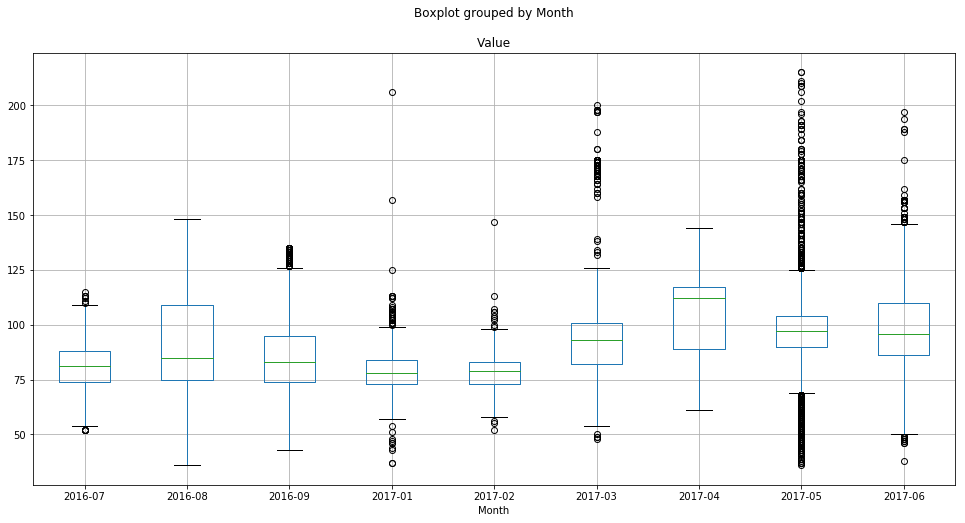

In [11]:
myd.boxplot(by='Month',column="Value", return_type='axes')

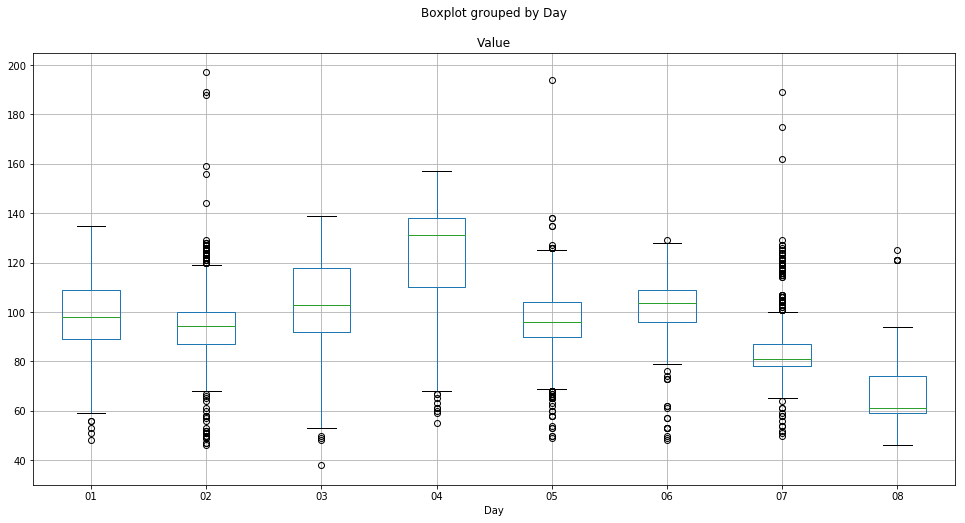

In [12]:
ax = myd[myd['Month']=='2017-06'].boxplot(by='Day',column="Value", return_type='axes')


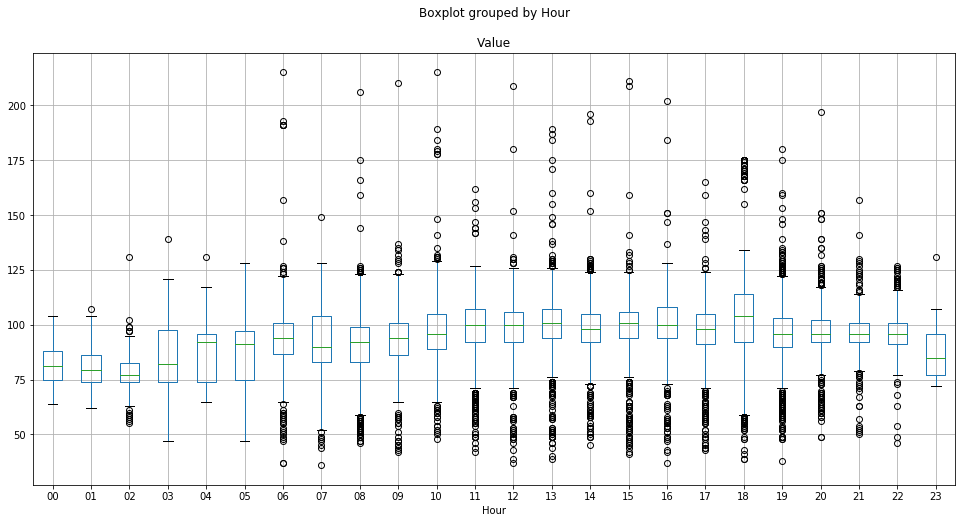

In [13]:
myd[myd['Month']=='2017-05'].boxplot(by='Hour',column="Value")

## Boxplots Using Seaborn

/opt/sasinside/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


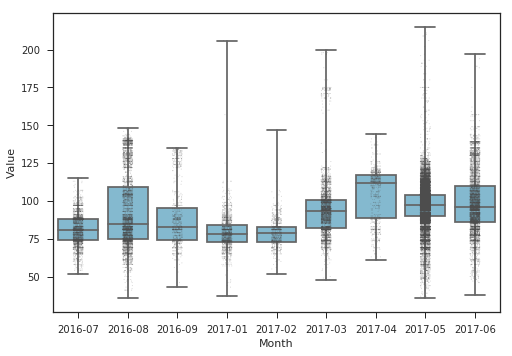

In [14]:
import numpy as np
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

sns.boxplot(x="Month", y="Value", data=myd,whis=np.inf, color="c")
# Add in points to show each observation
sns.stripplot(x="Month", y="Value", data=myd,jitter=True, size=1, alpha=.25, color=".3", linewidth=0)

## Load the tables into CAS

In [15]:
from swat import *
cashost='localhost'
casport=5570
casauth='~/.authinfo'
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

In [17]:
# list available caslibs
sess.caslibinfo()

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden
0,CASUSER(sasdemo),PATH,Personal File System Caslib,/home/sasdemo/casuser/,,1.0,0.0,1.0,1.0,0.0
1,DemoData,PATH,"DemoCenter Shared and writeable caslib, access...",/opt/sasinside/DemoData/,,0.0,0.0,0.0,0.0,0.0
2,Formats,PATH,Stores user defined formats.,/opt/sas/viya/config/data/cas/default/formats/,,1.0,0.0,0.0,0.0,0.0
3,Models,PATH,Stores models created by Visual Analytics for ...,/opt/sas/viya/config/data/cas/default/models/,,0.0,0.0,0.0,0.0,0.0
4,Public,PATH,"Shared and writeable caslib, accessible to all...",/opt/sas/viya/config/data/cas/default/public/,,1.0,0.0,0.0,0.0,0.0
5,SystemData,PATH,"Stores application generated data, used for ge...",/opt/sas/viya/config/data/cas/default/sysData/,,0.0,0.0,0.0,0.0,0.0


In [16]:
# Load necessary actionsets
sess.loadactionset(actionset="table")

NOTE: Added action set 'table'.


[actionset]

 'table'

+ Elapsed: 0.0017s, user: 0.002s, mem: 0.0577mb

In [26]:
sess.droptable(name='AppleHeartrate')

NOTE: Cloud Analytic Services dropped table AppleHeartrate from caslib CASUSER(sasdemo).


+ Elapsed: 0.00177s, sys: 0.001s, mem: 0.0308mb

In [28]:
upRes = sess.upload(data=myd,casout='AppleHeartrate')
sess.promote(name='AppleHeartrate')
ahr = upRes.casTable

NOTE: Cloud Analytic Services made the uploaded file available as table APPLEHEARTRATE in caslib CASUSER(sasdemo).
NOTE: The table APPLEHEARTRATE has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


In [29]:
sess.table.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,APPLEHEARTRATE,43219,5,utf-8,08Jun2017:18:47:32,08Jun2017:18:47:32,UTF8,1.812567e+09,1.812567e+09,1,0,0,,,0,sasdemo,


## Now the table is in a public space in CAS, it is availble in VA